#### 匯入函式庫

In [1]:
#匯入函式庫，數值矩陣計算numpy，以及畫圖用的matplotlib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#匯入
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
import tensorflow as tf

In [4]:
#文件搜索的工具
import glob

#這是一個看迴圈進度條的小工具
from tqdm import tqdm 

#匯入電腦視覺的函式庫，作影像讀取和分析使用
import cv2

### 定義測試資料

In [5]:
#欲分類的lable與數量
labels_name = ['NORMAL', 'PNEUMONIA']
num_classes = len(labels_name)


In [6]:
#建立訓練資料所在的路徑位置與對應的label：(filelist, label)
#label為數字，0代表'NORMAL'、1代表'PNEUMONIA'
filelist = []
label = []
for i in labels_name:
    class_num = labels_name.index(i)
    pathfile = glob.glob('chest_xray/test/'+str(i)+'/*.jpeg')
    
    for p in pathfile:
        filelist.append(p)
        label.append(class_num)

In [7]:
print('numbers of img:',len(filelist))

numbers of img: 624


In [8]:
#影像縮放大小
desired_size = 256

In [9]:
#定義一個縮放影像(img)至指定大小(desired_size)的函數
#等比例縮小，其他地方補黑邊
def squared(img, desired_size):
    old_size = img.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_img

### 開始讀入影像

In [10]:
#先宣告一個指定大小的ndarray
x_test = np.zeros((len(filelist),desired_size,desired_size,3), dtype=np.float32)

In [11]:
#開始讀入影像
for i in tqdm(range(len(filelist))):
    img = cv2.imread(filelist[i],cv2.IMREAD_GRAYSCALE)
    new_img = squared(img, desired_size)

#進行正規化(normalization)，常用除255或z-score
    m = np.mean(new_img)
    s = np.std(new_img)
    t = (new_img-m)/s
#    t=new_img/255

#三個channel可給予不同的處理手法
    x_test[i,:,:,0]=t
    x_test[i,:,:,1]=t
    x_test[i,:,:,2]=t

100%|██████████| 624/624 [00:03<00:00, 161.89it/s]


### 模型匯入與切分資料集

In [12]:
#撰寫模型的路徑
model_name = 'x_ray'
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_path = os.path.join(save_dir, model_name)

In [13]:
#載入訓練好的模型
model = tf.keras.models.load_model(model_path)

### 預測結果

In [14]:
#使用AI模型作預測
pred=model.predict(x_test)

In [15]:
#將預測的機率轉換成類別
ans=np.argmax(pred, axis=-1)

In [16]:
#畫出混淆矩陣
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(label, ans)
print(cf_matrix)

[[128 106]
 [  1 389]]


<AxesSubplot:>

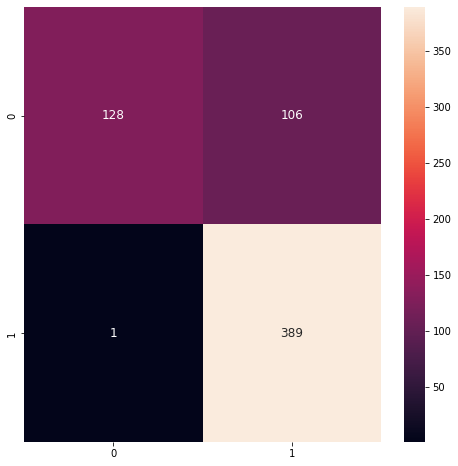

In [17]:
#對混淆矩陣畫圖
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cf_matrix, fmt='g', annot=True, annot_kws={"size":12})

In [18]:
#計算統計指標
from sklearn.metrics import classification_report
report = classification_report(label, ans)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.55      0.71       234
           1       0.79      1.00      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624

